### Causal Learning on Titanic Dara

Import necessary libraries

In [2]:
import numpy as np 
import pandas as pd
import sklearn
import seaborn as sns
from scipy import stats
from scipy.stats import hypergeom
import matplotlib.pyplot as plt

The titanic data is collected from Kaggle. The challenge is to use machine learning to create a model that predicts which passengers survived the Titanic shipwreck. 
Getting the data and data exploration.

In [3]:
train = pd.read_csv("/content/sample_data/train.csv")
test = pd.read_csv("/content/sample_data/test.csv")

## Exploratory Data Analysis

In [4]:
train.info

<bound method DataFrame.info of      PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                   

The training-set has 891 examples and 11 features + the target variable (survived). 2 of the features are floats, 5 are integers and 5 are objects.
The 11 features description are as follows:

survival:    Survival 
PassengerId: Unique Id of a passenger. 
pclass:    Ticket class     
sex:    Sex     
Age:    Age in years     
sibsp:    # of siblings / spouses aboard the Titanic     
parch:    # of parents / children aboard the Titanic     
ticket:    Ticket number     
fare:    Passenger fare     
cabin:    Cabin number     
embarked:    Port of Embarkation

In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


From the above table, we can say that 38% out of the training-set survived the Titanic. The age group varies from 0.4 to 80 years old. 

In [6]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


From the table above, we can make a couple of observations.
First of all, we can see that the features have widely different ranges, that we will need to convert into roughly the same scale.
Furthermore, that we need to convert a lot of features into numeric ones later on, so that the machine learning algorithms can process them.  
We can observe some features with missing values(NaN), which is better to deal with now.

Let us now check how many missing values are there in each feature. 

In [7]:
total = train.isnull().sum().sort_values(ascending=False)
percent_1 = train.isnull().sum()/train.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
PassengerId,0,0.0
Survived,0,0.0


We see that the Cabin has most missing feature and it would be wise to drop it now to avoid any mis-correlations are the end. Age has ~20% missing values which is concern as it is one of important features. 

Let us identify different features and how they are correlated. 

In [8]:
train.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

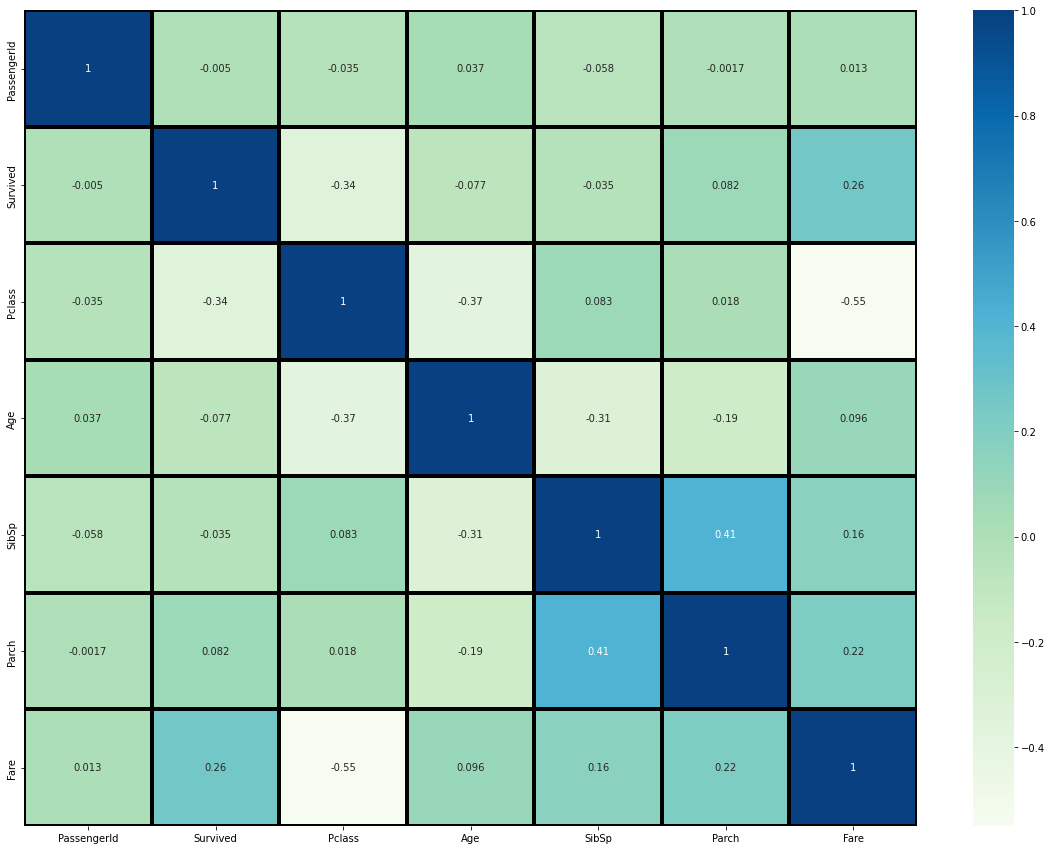

In [9]:
plt.figure(figsize=(20,15))
sns.heatmap(train.corr(), annot=True, linewidths=3, linecolor='black', cmap='GnBu');

But the more important question is, **What features could contribute to a high survival rate ?**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


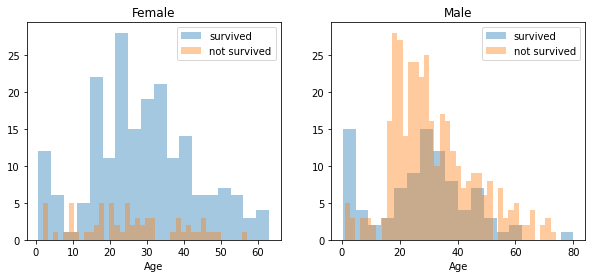

In [10]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = train[train['Sex']=='female']
men = train[train['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')

## Finding Association between label and features using HNet

When we talk about association, it means that certain values of one variable tend to co-occur with certain values of the other variable.

In [11]:
pip install hnet

     |████████████████████████████████| 49 kB 4.3 MB/s 
     |████████████████████████████████| 136 kB 19.6 MB/s 
     |████████████████████████████████| 216 kB 61.3 MB/s 
     |████████████████████████████████| 94 kB 2.5 MB/s 
     |████████████████████████████████| 203 kB 50.8 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=7672c2170fa415e4b8f328643153fc10c69d9198e2fff61d8fd2c81b0063f4b6
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [27]:
# Import HNet library
from hnet import hnet
hn = hnet(alpha=0.05, y_min=10, perc_min_num=0.8, multtest='holm', dtypes='pandas')

In [13]:
N=train.shape[0]              
K=sum(train['Survived']==1)   
n=sum(train['Sex']=='female') 
x=sum((train['Sex']=='female') & (train['Survived']==1))

print(x-1, N, n, K)


232 891 314 342


In [14]:
P = hypergeom.sf(x-1, N, n, K)
print(P)

3.5925132664684234e-60


In this step, we will pre-process the 12 input features; typing and one-hot encoding. 

In [15]:
results = hn.association_learning(train)


[df2onehot] >Auto detecting dtypes.


100%|██████████| 12/12 [00:00<00:00, 40.49it/s]


[df2onehot] >Set dtypes in dataframe..


100%|██████████| 12/12 [00:00<00:00, 97.72it/s] 


[df2onehot] >Total onehot features: 19
[hnet] >Association learning across [19] categories.


100%|██████████| 19/19 [00:15<00:00,  1.20it/s]


[hnet] >Multiple test correction using holm
[hnet] >Dropping PassengerId
[hnet] >Dropping Age
[hnet] >Dropping Fare
----------------------------------------------------
[hnet] >Total number of associatons computed: [2162]
----------------------------------------------------
[hnet] >Computing category association using fishers method..


100%|██████████| 10/10 [00:00<00:00, 176.54it/s]

[hnet] >Fin.


When variables are black listed, they are excluded from the search and the resulting model will not contain any of those edges. If variables are white listed, the search is limited to only those edges. The resulting model will then only contain edges that are in white_list.

In [49]:
train_df= pd.read_csv("/content/sample_data/train.csv")
test_df=pd.read_csv("/content/sample_data/train.csv")

In [29]:
hn = hnet(alpha=0.05, y_min=10, perc_min_num=0.8, multtest='holm', dtypes='pandas')
hn = hnet(black_list=['PassengerId','Name'])
hn = hnet(white_list=['Survived', 'Pclass', 'Age', 'SibSp'])


results = hn.association_learning(train_df)

[hnet] >Keeping ony features in the white list..

[df2onehot] >Auto detecting dtypes.


100%|██████████| 4/4 [00:00<00:00, 133.44it/s]


[df2onehot] >Set dtypes in dataframe..


100%|██████████| 4/4 [00:00<00:00, 151.89it/s]


[df2onehot] >Total onehot features: 10
[hnet] >Association learning across [10] categories.


100%|██████████| 10/10 [00:00<00:00, 34.73it/s]


[hnet] >Multiple test correction using holm
[hnet] >Dropping Age
---------------------------------------------------
[hnet] >Total number of associatons computed: [156]
---------------------------------------------------
[hnet] >Computing category association using fishers method..


100%|██████████| 4/4 [00:00<00:00, 330.76it/s]

[hnet] >Fin.


[hnet] >Building static network graph..


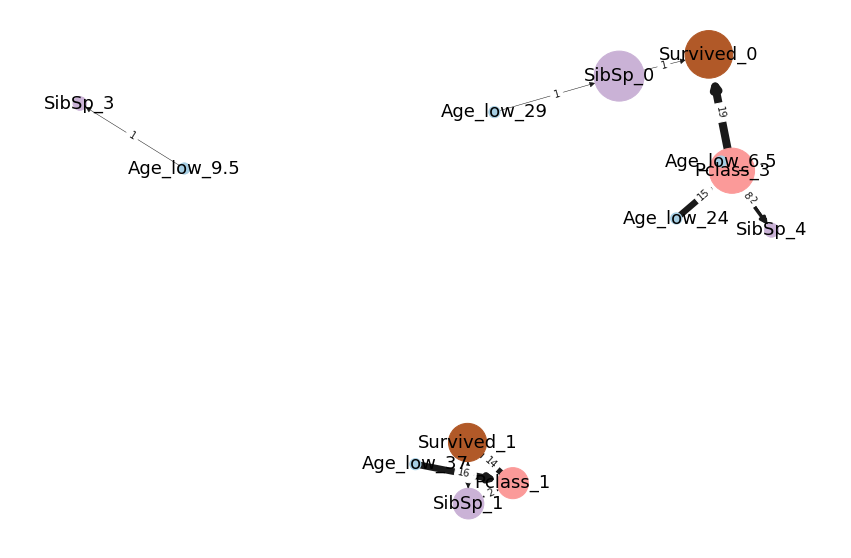

In [30]:
G1 = hn.plot()

[hnet] >Building static heatmap.


<Figure size 576x432 with 0 Axes>

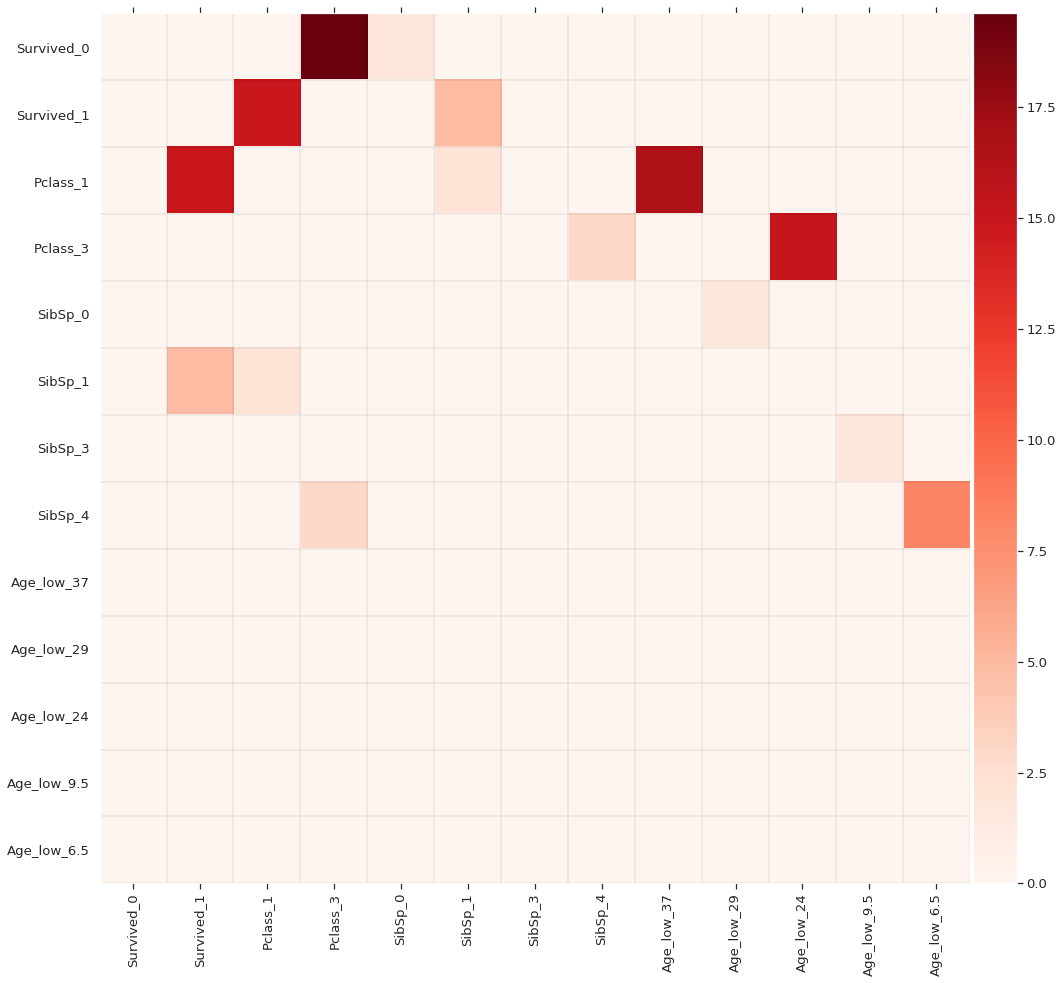

In [38]:
# Make static heatmap
plt.figure(figsize=(8, 6))
G2 = hn.heatmap()


In [20]:
# Make interactive network plot
G3 = hn.d3graph()

[hnet] >Building dynamic network graph using d3graph..
[hnet] >Creating output html..
[d3graph] >Removing special chars and replacing with "_"
[d3graph] >Writing /tmp/index.html


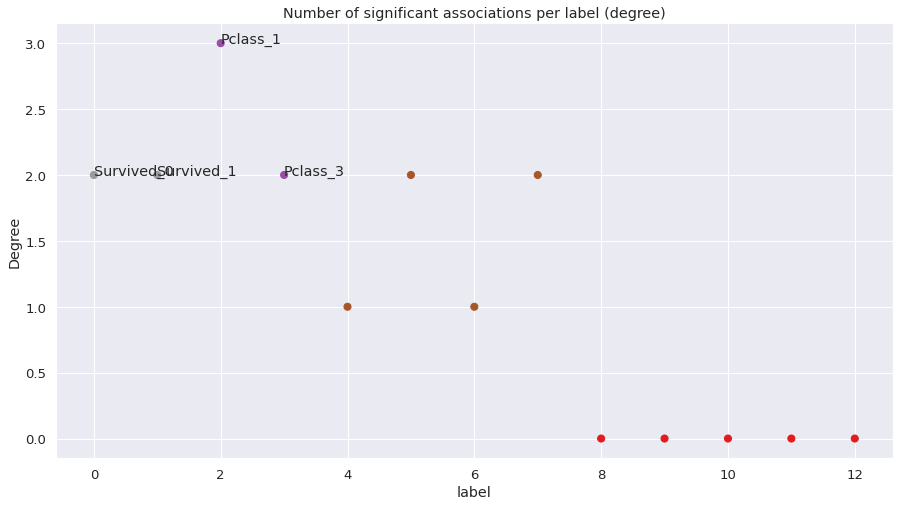

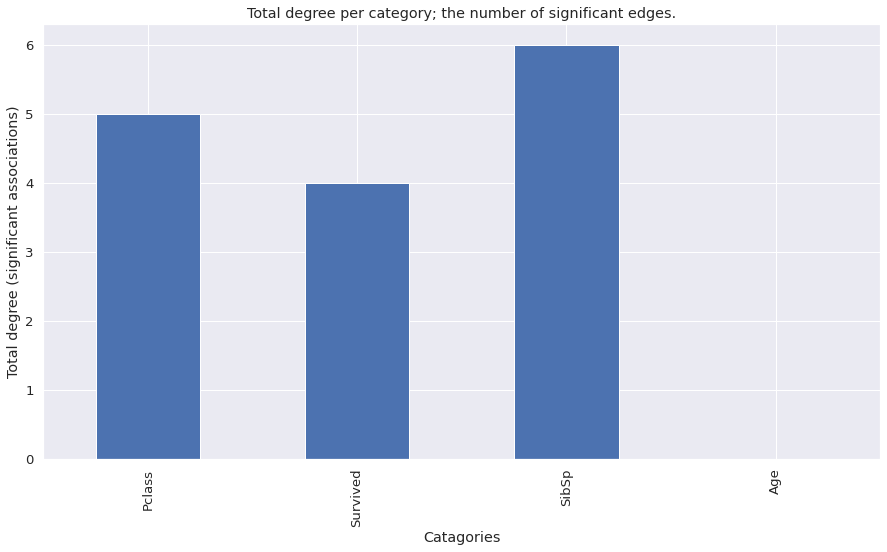

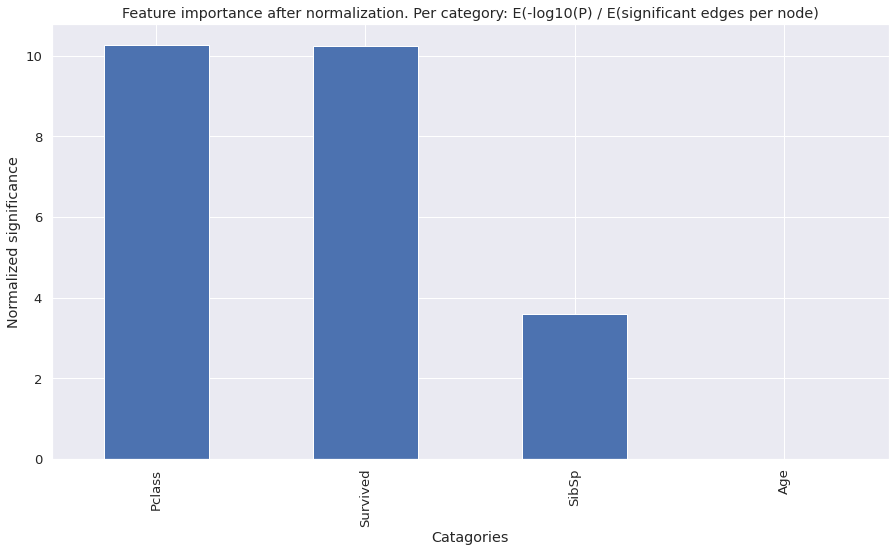

In [31]:
hn.plot_feat_importance(marker_size=50)

In [ ]:
results = hn.association_learning(train_df)

[hnet] >Building static heatmap.


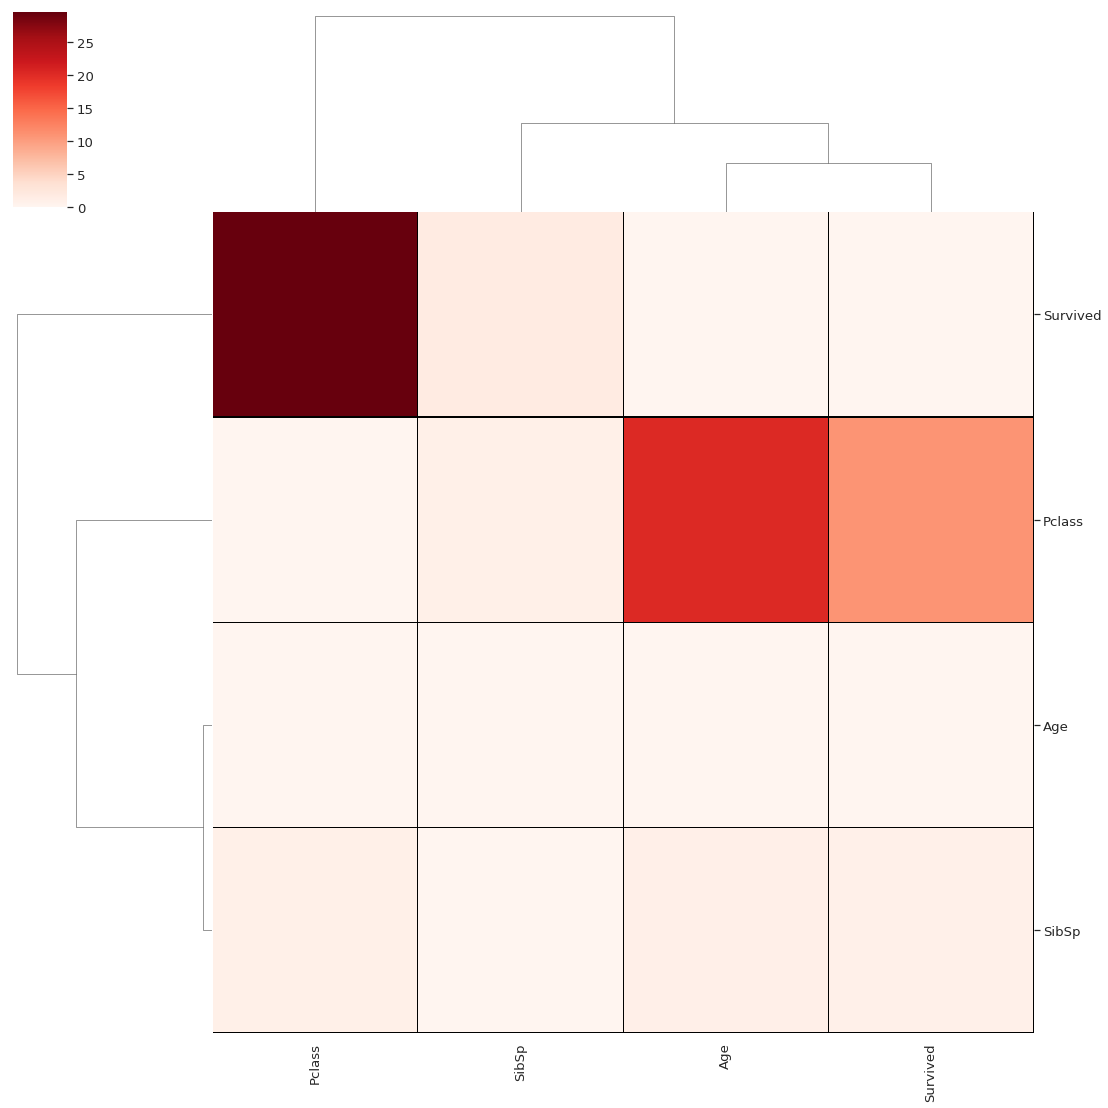

[hnet] >Building dynamic heatmaps using d3graph..
[hnet] >Building static network graph..
[hnet] >Clustering using best partition
[hnet] >Creating output html..
[d3heatmap] >Scaling image between [min-100]


{'clust_labx': array([0, 0, 0, 0]),
 'paths': {'csv': '/tmp/index.csv',
  'dirpath': '/tmp',
  'filename': 'index.html',
  'path': '/tmp/index.html'}}

In [39]:
sns.set(rc = {'figure.figsize':(15,8)})
hn.heatmap(summarize=True, cluster=True)
hn.d3heatmap(summarize=True)

[hnet] >Building static network graph..


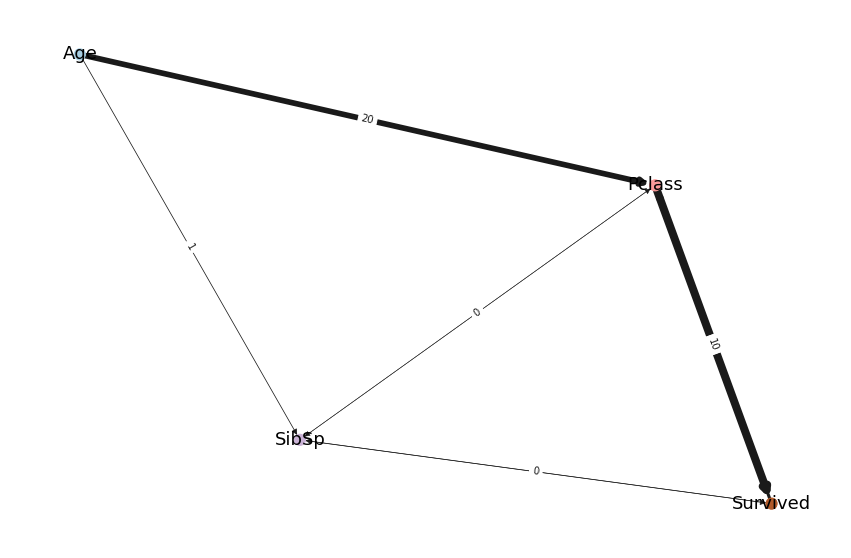

[hnet] >Building dynamic network graph using d3graph..
[hnet] >Creating output html..
[d3graph] >Removing special chars and replacing with "_"
[d3graph] >Writing /tmp/index.html


In [47]:
hn.plot(summarize=True)
edges=hn.d3graph(summarize=True, charge=1000)

In [42]:
!pip install pgmpy

     |████████████████████████████████| 1.9 MB 10.1 MB/s 


## Modelling

In [54]:
from sklearn.naive_bayes import GaussianNB
import re

In [55]:

deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train_df, test_df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
# we can now drop the cabin feature
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

In [56]:
data = [train_df, test_df]

for dataset in data:
    mean = train_df["Age"].mean()
    std = test_df["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_df["Age"].astype(int)
train_df["Age"].isnull().sum()

0

In [58]:
common_value = 'S'
for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

In [59]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    int64  
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
 11  Deck         891 non-null    int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 83.7+ KB


In [61]:
for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

In [62]:
data = [train_df, test_df]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    dataset['Title'] = dataset['Title'].map(titles)
    dataset['Title'] = dataset['Title'].fillna(0)
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

In [63]:
genders = {"male": 0, "female": 1}
data = [train_df, test_df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

In [64]:
train_df['Ticket'].describe()

count        891
unique       681
top       347082
freq           7
Name: Ticket, dtype: object

In [65]:
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

In [66]:
ports = {"S": 0, "C": 1, "Q": 2}
for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

In [68]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()

In [69]:
gaussian = GaussianNB() 
gaussian.fit(X_train, Y_train)  
Y_pred = gaussian.predict(X_test)  
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)

ValueError: ignored